In [27]:
import sys

sys.path.append("../")


from time_series_parser import *
import polars as pl
import matplotlib.pyplot as plt

In [46]:
df = parse_fit_file(
    "/home/sayantan/Downloads/First_buttery_of_the_year_with_the_gang.fit"
)

In [47]:
df.describe().select(pl.col("statistic"), pl.col("power (watts)"))

statistic,power (watts)
str,f64
"""count""",10831.0
"""null_count""",20.0
"""mean""",151.751546
"""std""",120.038401
"""min""",0.0
"""25%""",39.0
"""50%""",151.0
"""75%""",238.0
"""max""",696.0


In [49]:
df = df.with_columns(
    pl.col("power (watts)")
    .cut(
        [
            0,
            140,
            191,
            229,
            # 268,
            # 306,
            # 382,
            # 1000,
        ],
        left_closed=True,
    )
    .alias("Power bucket"),
    pl.col("power (watts)").rolling_mean(300).alias("10s Power"),
)

In [50]:
df.select(pl.col("^.*(P|p)ower.*$"))

power (watts),accumulated_power (watts),Power bucket,10s Power
i64,i64,cat,f64
0,null,"""[0, 140)""",null
0,null,"""[0, 140)""",null
null,null,null,null
0,null,"""[0, 140)""",null
0,null,"""[0, 140)""",null
…,…,…,…
0,1650828,"""[0, 140)""",153.876667
0,1650828,"""[0, 140)""",153.306667
0,1650828,"""[0, 140)""",152.65


In [51]:
df.group_by(pl.col("Power bucket")).len().with_columns(
    (pl.col("len") / df.shape[0] * 100).alias("Fraction")
)

Power bucket,len,Fraction
cat,u32,f64
null,20,0.184315
"""[191, 229)""",1140,10.505944
"""[0, 140)""",5109,47.083218
"""[140, 191)""",1595,14.699106
"""[229, inf)""",2987,27.527417


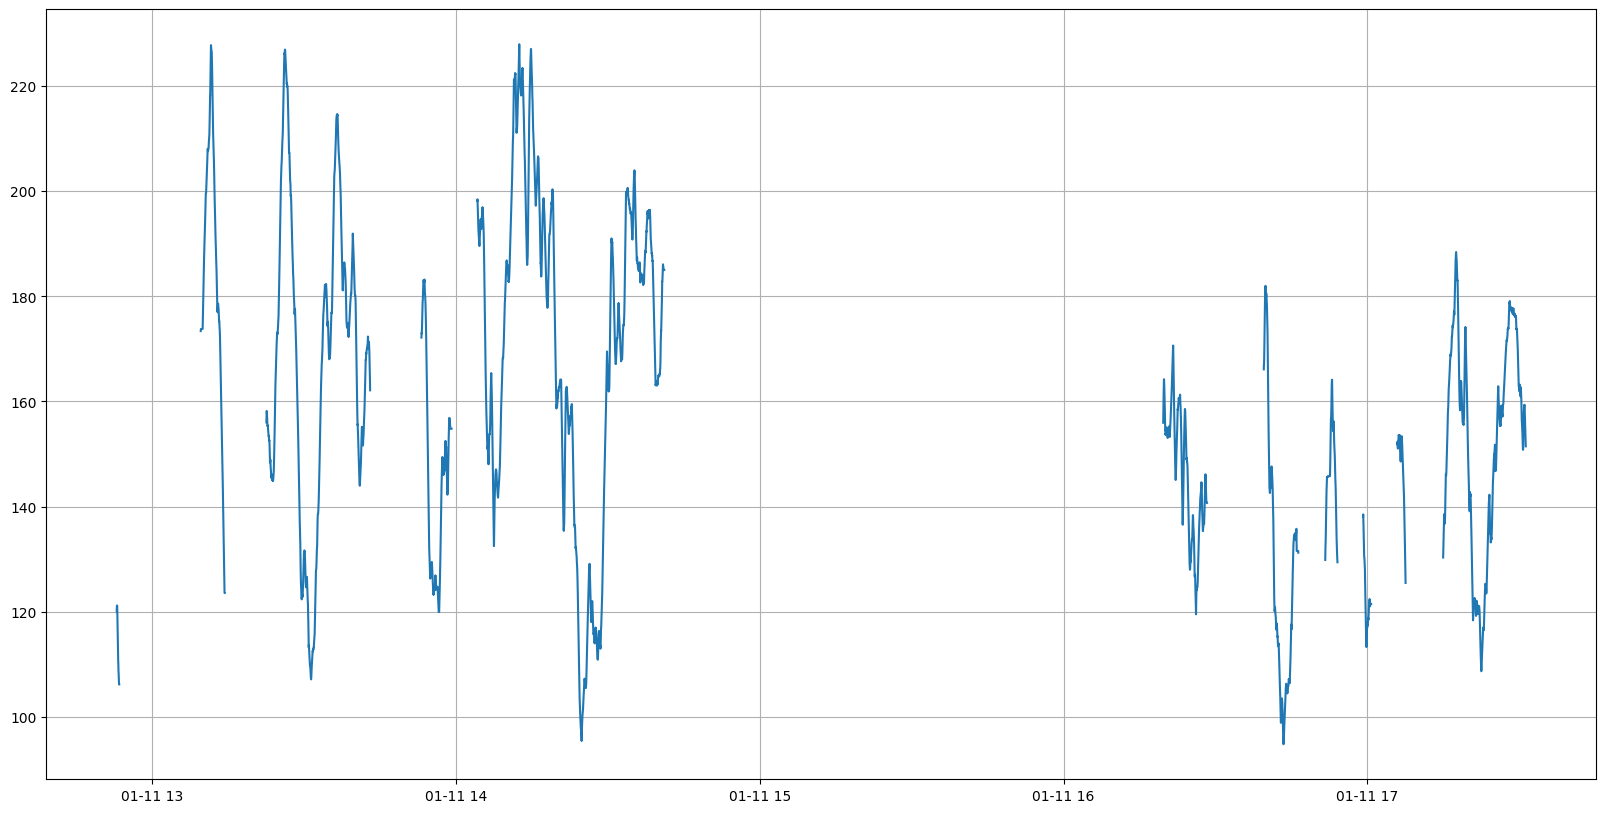

In [52]:
plt.figure(figsize=(20, 10))

plt.plot(
    df["timestamp (None)"],
    df["10s Power"],
    # alpha=0.5,
)

plt.grid()